In [1]:
import numpy as np
import torch
import math
import fastai
from PIL import Image
from diffusers import DiffusionPipeline
from diffusers.utils import pt_to_pil
from dataloader import get_imagenette_dataloader
from quantize import quantize_img, plot_imgs

device = "cuda"

In [2]:
def method_helper(o): return list(filter(lambda x: x[0] != "_", dir(o)))

In [3]:
dl = get_imagenette_dataloader("/mnt/wd/datasets/imagenette2")

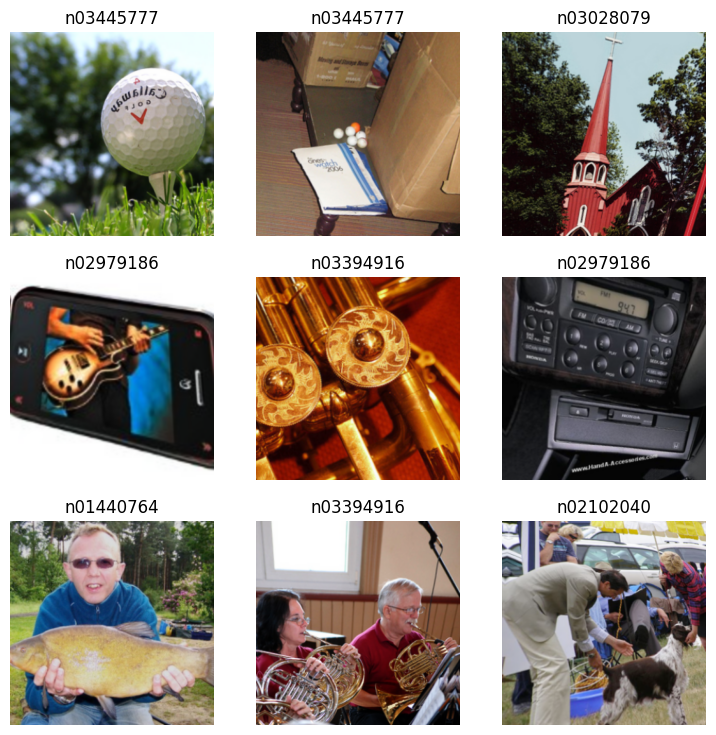

In [4]:
batch = next(iter(dl))
batch.show_batch()

In [5]:
print(type(batch))

<class 'fastai.data.core.TfmdDL'>


In [6]:
# method_helper(type(batch))

In [7]:
img = batch.decode_batch(batch.one_batch())[0]

(320, 320, 3)


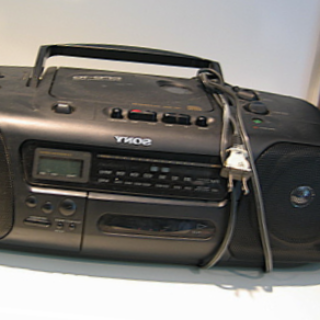

In [8]:
img = img[0].numpy().astype(np.uint8).transpose((1,2,0))
print(img.shape)
image = Image.fromarray(img)
image

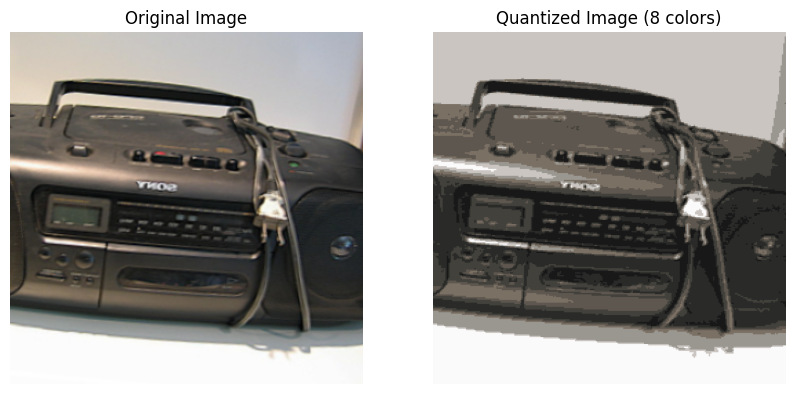

In [9]:
num_colors = 8
quant_img = quantize_img(image, num_colors)
plot_imgs(img, quant_img, num_colors)

In [10]:
from huggingface_hub import login

# login()

In [11]:
stage_1 = DiffusionPipeline.from_pretrained("DeepFloyd/IF-I-XL-v1.0", variant="fp16", torch_dtype=torch.float16)
# stage_1.enable_model_cpu_offload()


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [12]:
# stage 2
stage_2 = DiffusionPipeline.from_pretrained(
    "DeepFloyd/IF-II-L-v1.0", text_encoder=None, variant="fp16", torch_dtype=torch.float16
)
# stage_2.enable_model_cpu_offload()

# stage 3
# safety_modules = {"feature_extractor": stage_1.feature_extractor, "safety_checker": stage_1.safety_checker, "watermarker": stage_1.watermarker}
# stage_3 = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-x4-upscaler", **safety_modules, torch_dtype=torch.float16)
# stage_3.enable_model_cpu_offload()
#
# prompt = 'a photo of a kangaroo wearing an orange hoodie and blue sunglasses standing in front of the eiffel tower holding a sign that says "very deep learning"'

# text embeds
# prompt_embeds, negative_embeds = stage_1.encode_prompt(prompt)

# generator = torch.manual_seed(0)

# stage 1
# image = stage_1(prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds, generator=generator, output_type="pt").images
# pt_to_pil(image)[0].save("./if_stage_I.png")

# stage 2
# image = stage_2(
#     image=image, prompt_embeds=prompt_embeds, negative_prompt_embeds=negative_embeds, generator=generator, output_type="pt"
# ).images
# pt_to_pil(image)[0].save("./if_stage_II.png")

# stage 3
# image = stage_3(prompt=prompt, image=image, generator=generator, noise_level=100).images
# image[0].save("./if_stage_III.png")


A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.safetensors, text_encoder/model.fp16-00002-of-00002.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [13]:
quant_img_pil = Image.fromarray(quant_img)

In [14]:
unet_2 = stage_2.unet.to("cuda")

In [15]:
# stage_1

IFPipeline {
  "_class_name": "IFPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "DeepFloyd/IF-I-XL-v1.0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "deepfloyd_if",
    "IFSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "T5EncoderModel"
  ],
  "tokenizer": [
    "transformers",
    "T5Tokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "watermarker": [
    "deepfloyd_if",
    "IFWatermarker"
  ]
}

In [16]:
scheduler = stage_1.scheduler

# Load the UNet model - the core denoiser
unet = stage_1.unet.to("cuda")

# Example: Create a noise tensor
image_shape = (1, 3, 64, 64)  # Batch size 1, 3 color channels, 64x64 image
noisy_image = torch.randn(image_shape, dtype=torch.float16, device="cuda")

# Predict denoised image using UNet
with torch.no_grad():
    noise_pred = unet(noisy_image, torch.tensor([1.0], device="cuda")).sample  # Predict noise

# Use scheduler to step back in denoising
denoised_image = scheduler.step(noise_pred, 1.0, noisy_image).prev_sample

TypeError: UNet2DConditionModel.forward() missing 1 required positional argument: 'encoder_hidden_states'

In [28]:
from fastai.vision.all import Callback, ImageDataLoaders, Resize
class DiffusionTrainingCallback(Callback):
    """Custom FastAI callback for training a UNet diffusion model with DeepFloyd's DDPM Scheduler."""

    def __init__(self, unet, scheduler, timesteps=1000):
        self.unet = unet
        self.scheduler = scheduler
        self.timesteps = timesteps  # Number of diffusion steps

    def before_batch(self):
        """Add noise to the input images before passing them to the model."""
        # Get the real images from the batch
        images = self.xb[0]  # FastAI batches are tuples (images, labels)

        # Sample random timesteps (uniformly distributed)
        batch_size = images.shape[0]
        t = torch.randint(0, self.timesteps, (batch_size,), device=images.device).long()

        # Generate Gaussian noise
        noise = torch.randn_like(images)

        # Apply forward diffusion (add noise to images)
        noisy_images = self.scheduler.add_noise(images, noise, t)

        # Replace batch input with noisy images
        self.learn.xb = (noisy_images, t)

        # Store ground-truth noise as the target for training
        self.learn.yb = (noise,)

    def after_pred(self):
        """Compute loss: Train UNet to predict noise (MSE loss)."""
        noise_pred = self.pred  # UNet output: Predicted noise
        noise_true = self.yb[0]  # Ground-truth noise

        # Compute Mean Squared Error (MSE) loss
        self.learn.loss = nn.functional.mse_loss(noise_pred, noise_true)

    def after_batch(self):
        """Zero gradients manually after each batch (recommended for diffusion)."""
        self.learn.opt.zero_grad(set_to_none=True)

In [34]:
dls = ImageDataLoaders.from_folder("/mnt/wd/datasets/imagenette2", valid_pct=0.1, item_tfms=Resize(224))

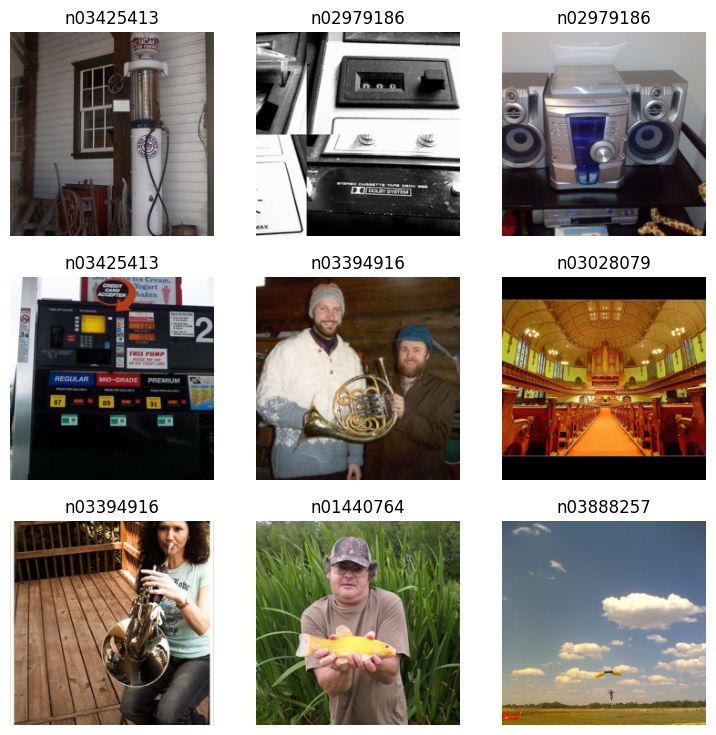

In [35]:
dls.show_batch()

In [17]:
# cosine_scheduler = CosineNoiseScheduler(num_timesteps=1000, device=device)

In [20]:
import torch.nn as nn
from transformers import ViTModel, ViTImageProcessor
class ViTImageEncoder(nn.Module):
    """
    Uses a pre-trained ViT model to extract embeddings from a quantized image.
    This replaces the CNN encoder with a stronger transformer-based encoder.
    """
    def __init__(self, model_name="google/vit-base-patch16-224", output_dim=1024):
        super().__init__()
        self.vit = ViTModel.from_pretrained(model_name)
        self.feature_extractor = ViTImageProcessor.from_pretrained(model_name)
        self.fc = nn.Linear(self.vit.config.hidden_size, output_dim)  # Resize to match UNet's expected size

    def forward(self, x):
        features = self.vit(x).last_hidden_state  # Extract token embeddings
        pooled_features = features.mean(dim=1)  # Global Average Pooling (B, D)
        return self.fc(pooled_features).unsqueeze(1)  # Shape: (batch, 1, output_dim)

# =============================
# 2️⃣ Load DeepFloyd IF UNet & Scheduler
# =============================


encoder = ViTImageEncoder(output_dim=unet.config.cross_attention_dim).to(device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
encoder

ViTImageEncoder(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768

In [ ]:
def run_dequantization(image, pipe):
    """
    Uses DeepFloyd IF Stage I for dequantization (restoring natural colors).
    
    Parameters:
    - image: PIL Image (quantized version)

    Returns:
    - Restored image as a PIL Image
    """
    # Load DeepFloyd IF Stage I model


    # Convert image to tensor (normalize to -1 to 1 for diffusion models)
    image = image.resize((64, 64))  # DeepFloyd IF Stage I uses 64x64 inputs
    image_np = np.array(image).astype(np.float32) / 127.5 - 1  # Normalize
    image_tensor = torch.tensor(image_np).permute(2, 0, 1).unsqueeze(0).to("cuda")

    # Run inference
    with torch.no_grad():
        output = pipe(image=image_tensor).images[0]

    return output

# Load and quantize an image

quantized_image = quant_img_pil

# Run DeepFloyd IF Stage I for dequantization
restored_image = run_dequantization(quantized_image, stage_2)

In [ ]:
# Display results
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].imshow(original_image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(quantized_image)
ax[1].set_title("Quantized Image (16 colors)")
ax[1].axis("off")

ax[2].imshow(restored_image)
ax[2].set_title("Dequantized Image (DeepFloyd IF Stage I)")
ax[2].axis("off")

plt.show()

TypeError: UNet2DConditionModel.forward() missing 1 required positional argument: 'encoder_hidden_states'